In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [ ]:
df = pd.read_csv("/content/Total Requests _ Cluster - L7-C1 _ Domain - All _ Node - All  _ Day Wise-data-2025-06-11 22_56_31.csv")

df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
df[df.columns[1]] = df[df.columns[1]].astype('float64')
df.iloc[:, 1] = df.iloc[:, 1] / 1_000_000

print(df.head())

                  TIME      L7-C1
0  2025-03-08 04:00:00  19.219275
1  2025-03-08 05:00:00  18.109506
2  2025-03-08 06:00:00  21.510024
3  2025-03-08 07:00:00  20.552204
4  2025-03-08 08:00:00  20.323129


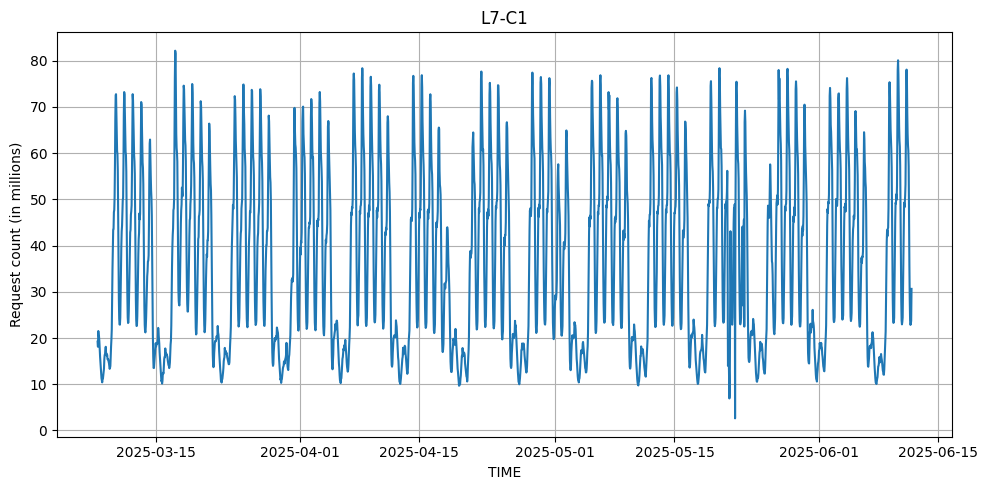

In [ ]:
#Initial data visualization

plt.figure(figsize=(10, 5))
plt.plot(df.iloc[:, 0], df.iloc[:, 1])
plt.title(df.columns[1])
plt.xlabel(df.columns[0])
plt.ylabel("Request count (in millions)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
total_len = len(df)
train_size = int(total_len * 0.7)
val_size = int(total_len * 0.15)
test_size = total_len - train_size - val_size

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Train: 1605, Validation: 343, Test: 345


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_scaled = scaler.fit_transform(train_df[[df.columns[1]]])
val_scaled = scaler.transform(val_df[[df.columns[1]]])
test_scaled = scaler.transform(test_df[[df.columns[1]]])

# a = train_df['Count_normalized'].tolist()
# b = val_df["Count_normalized"].tolist()
# c = test_df["Count_normalized"].tolist()

In [ ]:
def create_sequences(data, window_size=168*2):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = create_sequences(train_scaled)
X_val, y_val = create_sequences(val_scaled)
X_test, y_test = create_sequences(test_scaled)

# _1 = scaler.inverse_transform(y_train)
# y_train = np.log1p(_1)
# _2 = scaler.inverse_transform(y_val)
# y_val = np.log1p(_2)
# _3 = scaler.inverse_transform(y_test)
# y_test = np.log1p(_3)

#LSTM-required shape: (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (1269, 336, 1)
y_train shape: (1269, 1)


In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    keras.layers.Dropout(0.3),
    # keras.layers.Dense(8, activation="relu"),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.3),
    # keras.layers.Lambda(attention_layer),
    keras.layers.LSTM(32),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1)
])

model.summary()
model.compile(optimizer="adam", loss="mse", metrics=[keras.metrics.RootMeanSquaredError()])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 336, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 336, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 336, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 336, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,929 (503.63 KB)

 Trainable params: 128,929 (503.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
training = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]
)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.7516 - root_mean_squared_error: 0.8643 - val_loss: 0.1876 - val_root_mean_squared_error: 0.4331 - learning_rate: 0.0010
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.2229 - root_mean_squared_error: 0.4717 - val_loss: 0.1580 - val_root_mean_squared_error: 0.3976 - learning_rate: 0.0010
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1567 - root_mean_squared_error: 0.3957 - val_loss: 0.0898 - val_root_mean_squared_error: 0.2997 - learning_rate: 0.0010
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1290 - root_mean_squared_error: 0.3591 - val_loss: 0.0815 - val_root_mean_squared_error: 0.2855 - learning_rate: 0.0010
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.1293 - root_mean_squared_error: 0.3594 - val_loss: 0.0863 - val_root_mean_squared_error: 0.2938 - learning_rate: 0.0010
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1078 - root_mean_squared_err

In [ ]:
test_loss, test_rmse = model.evaluate(X_test, y_test)
print(f"Test RMSE: {test_rmse:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0176 - root_mean_squared_error: 0.1327
Test RMSE: 0.1327


In [ ]:
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


In [ ]:
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

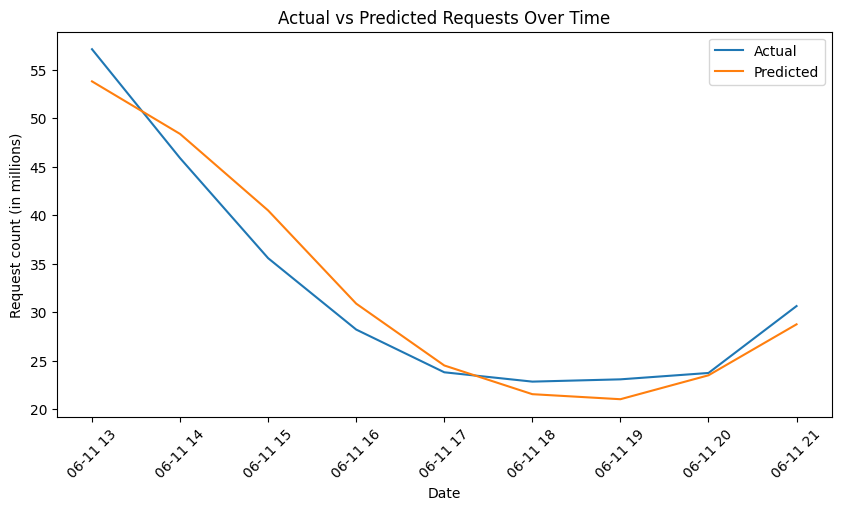

In [ ]:
dates = df[df.columns[0]][-len(y_test):]

plt.figure(figsize=(10, 5))
plt.plot(dates, y_test_inv, label="Actual")
plt.plot(dates, y_pred_inv, label="Predicted")
plt.xlabel("Date")
plt.ylabel("Request count (in millions)")
plt.title("Actual vs Predicted Requests Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [ ]:
last_sequence = X_test[-1]
predictions = []


for _ in range(600):
    pred = model.predict(last_sequence[np.newaxis, :, :])[0, 0]
    predictions.append(pred)
    last_sequence = np.append(last_sequence[1:], [[pred]], axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

In [ ]:
y = []
for i in range(len(predictions)):
  y.append(scaler.inverse_transform([[predictions[i]]])[0][0])
  y[i] = round(float(y[i]), 3)
print(y)

[28.744, 35.798, 42.247, 44.112, 44.973, 45.657, 47.204, 51.875, 59.382, 66.355, 70.968, 71.937, 69.091, 64.928, 60.44, 56.492, 52.184, 46.884, 38.854, 28.758, 22.729, 19.717, 18.748, 20.167, 24.858, 30.69, 36.222, 39.495, 40.038, 40.464, 41.22, 43.296, 49.319, 57.33, 63.41, 65.885, 63.902, 60.13, 56.547, 52.711, 48.009, 42.34, 33.326, 24.822, 20.089, 17.177, 16.569, 17.454, 19.408, 22.768, 24.76, 25.628, 25.791, 25.529, 25.652, 26.201, 27.197, 28.499, 29.848, 31.302, 31.835, 30.348, 27.535, 24.069, 21.41, 18.796, 16.529, 14.845, 13.978, 13.741, 13.891, 14.105, 14.222, 14.452, 14.779, 15.189, 15.667, 16.171, 16.653, 17.08, 17.431, 17.669, 17.738, 17.582, 17.175, 16.538, 15.761, 14.994, 14.373, 13.966, 13.778, 13.792, 13.999, 14.407, 15.037, 15.908, 17.019, 18.355, 19.893, 22.585, 25.49, 28.665, 32.519, 36.116, 39.242, 43.309, 48.051, 53.505, 59.236, 63.77, 65.572, 64.196, 61.259, 57.49, 53.252, 47.762, 39.581, 29.996, 24.371, 21.289, 20.252, 21.768, 25.7, 31.701, 39.322, 42.393, 43.557

In [ ]:
y = np.array(y)
forecast = pd.DataFrame(y, columns=[df.columns[0]])
n = forecast.shape[0]
print(n)
start_time = pd.Timestamp.now().floor('h')
date_range = [start_time + pd.Timedelta(hours=i) for i in range(n)]
forecast.index = date_range
print(forecast)

600
                       TIME
2025-06-13 05:00:00  28.744
2025-06-13 06:00:00  35.798
2025-06-13 07:00:00  42.247
2025-06-13 08:00:00  44.112
2025-06-13 09:00:00  44.973
...                     ...
2025-07-08 00:00:00  15.503
2025-07-08 01:00:00  15.501
2025-07-08 02:00:00  15.759
2025-07-08 03:00:00  16.315
2025-07-08 04:00:00  17.207

[600 rows x 1 columns]


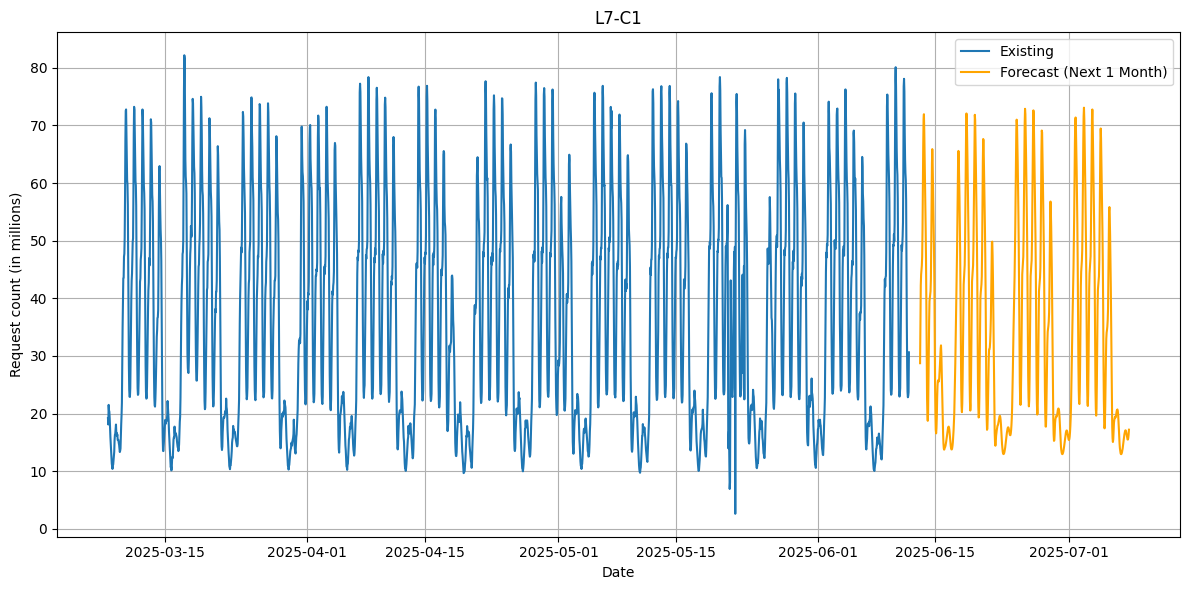

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df[df.columns[0]], df[df.columns[1]], label="Existing")
plt.plot(forecast.index, forecast, label="Forecast (Next 1 Month)", color="orange")
plt.title(df.columns[1])
plt.xlabel("Date")
plt.ylabel("Request count (in millions)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [1]:
!pip freeze > requirements.txt